# Machine Learning Pipeline - Feature Selection

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. Feature Engineering
3. **Feature Selection**
4. Model Training
5. Obtaining Predictions / Scoring

Our selection procedure will be focused solely on non-parametric statistical methods because they are model-agnostic. We avoid model-specific methods because:

1. They can be very computationally expensive. This project is being run on a local machine and not a distrubuted system.
2. Model-specific methods would require us to use the same model in training as we did in feature selection for consistency. This is impractical as we still have to run our data through a range of options during training before deciding on our most optimal model.

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
# to run statistical tests
from scipy.stats import kruskal, mannwhitneyu, spearmanr

In [3]:
# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns',None)

In [4]:
# load the train and test sets with the engineered variables
X_train = pd.read_csv('xtrain_unscaled.csv')
X_test = pd.read_csv('xtest_unscaled.csv')

In [5]:
X_train = X_train.drop('rank',axis=1)

In [6]:
X_train.head()

,symboling,country,carbody,drivewheel,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_gas,aspiration_turbo,doornumber_two
0,3,7,5,2,96.5,175.4,62.5,54.1,2372,6,110,3,3.15,3.580,9.0,86,5800,27,33,1,0,0
1,3,7,5,2,98.8,177.8,66.5,55.5,2410,6,122,5,3.39,3.390,8.6,84,4800,26,32,1,0,0
2,6,7,4,3,95.3,169.0,65.7,49.6,2380,2,70,2,3.33,3.255,9.4,101,6000,17,23,1,0,1
3,3,7,5,2,100.4,181.7,66.5,55.1,3095,5,181,7,3.43,3.270,9.0,152,5200,17,22,1,0,0
4,4,7,5,2,96.3,172.4,65.4,51.6,2405,6,122,5,3.35,3.460,8.5,88,5000,25,32,1,0,0


In [7]:
# load the target
y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

In [8]:
# visualise the target
y_train.head()

,price
0,10295.0
1,8495.0
2,11845.0
3,13499.0
4,8189.0


# Feature Selection

Let's go ahead and select a subset of the most predictive features.

## Drop constant features
Constant features show the same value for all observations in the dataset and provide no information value for a machine learning model. As a sanity check, we will check all our variables for constant features and remove them.

In [9]:
constant_features = [feat for feat in X_train.columns if X_train[feat].nunique() == 1]
constant_features

[]

We have no variables with constant values in the dataset.

## Drop quasi-constant features

Quasi-constant features also show the same value but only for the great majority of the observations. Like constant features, they provide little, if any, information value for any model to work with.

As another sanity check, we will also check all our columns for quasi-constant features and remove them.

In [10]:
# creat an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:
    
    # find the predominant value, i.e. the value shared
    # by most observations
    predominant = (X_train[feature].value_counts() / float(
        len(X_train))).sort_values(ascending=False).values[0]
    
    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

In [11]:
len(quasi_constant_feat)

0

In [12]:
quasi_constant_feat

[]

Our dataset does not have any variables with quasi-constant values.

## Drop correlated features

Good feature subsets contain features that are highly correlated with the target but uncorrelated with each other. Let's identify independent variables highly correlated with themselves.

We use the Spearman rank-order correlation using rank values instead of real values considering the non-parametric nature of our target.

In [13]:
corrmat = X_train.corr(method='spearman')

<AxesSubplot:>

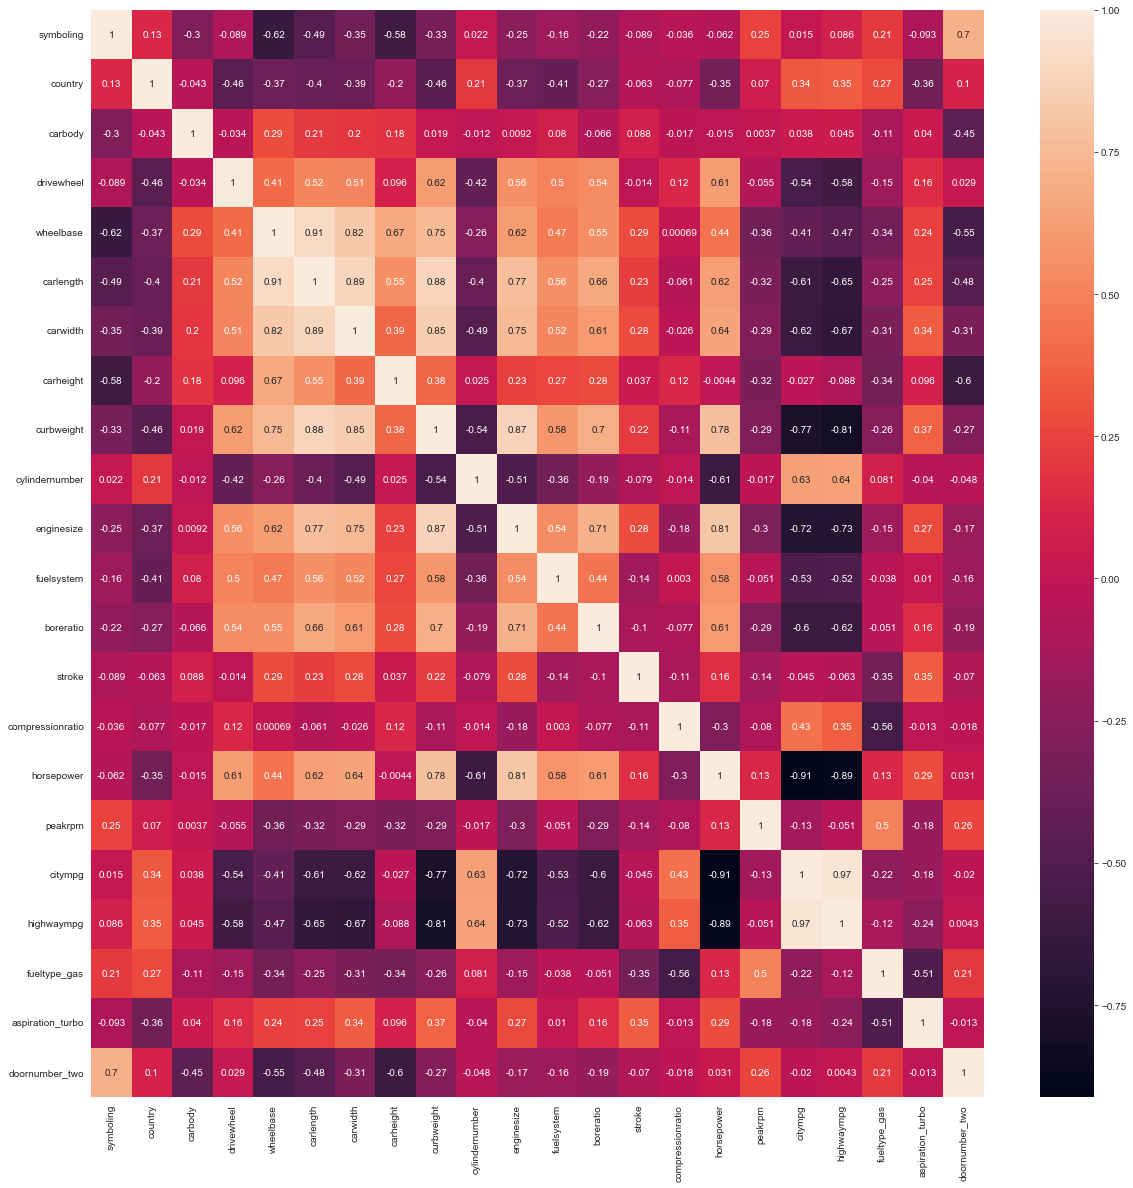

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True)

In [15]:
# pick out variable pairs with correlation coeeficients > 80%
# and < 1 to exclude variables self-correlating

corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1','feature2','corr']
corrmat

,feature1,feature2,corr
0,highwaympg,citympg,0.965623
1,citympg,highwaympg,0.965623
2,citympg,horsepower,0.911554
3,horsepower,citympg,0.911554
4,wheelbase,carlength,0.910906
5,carlength,wheelbase,0.910906
6,carlength,carwidth,0.889198
7,carwidth,carlength,0.889198
8,highwaympg,horsepower,0.886130
9,horsepower,highwaympg,0.886130


There are 11 groups of correlated independent variables in the dataset. Our next operation will find groups of correlated features.

In [16]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:
        
        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]
        
        # append the block of features to the list
        correlated_groups.append(correlated_block)

In [17]:
print(f'found {len(correlated_groups)} correlated groups')
print(f'out of {X_train.shape[1]} total features')

found 3 correlated groups
out of 22 total features


We can now print out each group. 

In [18]:
for group in correlated_groups:
    print(group)
    print()

      feature1    feature2      corr
0   highwaympg     citympg  0.965623
8   highwaympg  horsepower  0.886130
19  highwaympg  curbweight  0.814306

     feature1   feature2      corr
4   wheelbase  carlength  0.910906
17  wheelbase   carwidth  0.824141

      feature1    feature2      corr
12  enginesize  curbweight  0.873168
20  enginesize  horsepower  0.811445



Notice that all the groups present several features that are correlated among themselves. Let's print out the correlation coefficients and p-values of the variables in each group.

In [19]:
for group in correlated_groups:
    selected = []
    p_values = {}
    coefs = {}
    features = list(group['feature1'].unique())
    for var in group['feature2'].unique():
        features.append(var)
    for var in features:
        coef, p = spearmanr(X_train[var],y_train)
        p_values[var] = p
        coefs[var] = coef
    print('P Values')
    print(pd.Series(p_values).sort_values(ascending=True))
    print()
    print('Corr coefs')
    print(pd.Series(coefs).sort_values(ascending=False))
    print()

P Values
curbweight    7.134901e-53
horsepower    6.426631e-41
highwaympg    1.414944e-35
citympg       2.411341e-34
dtype: float64

Corr coefs
curbweight    0.900585
horsepower    0.849136
citympg      -0.808979
highwaympg   -0.817327
dtype: float64

P Values
carwidth     1.798629e-31
carlength    2.066912e-31
wheelbase    9.765077e-18
dtype: float64

Corr coefs
carwidth     0.787780
carlength    0.787306
wheelbase    0.638388
dtype: float64

P Values
curbweight    7.134901e-53
horsepower    6.426631e-41
enginesize    2.051266e-36
dtype: float64

Corr coefs
curbweight    0.900585
horsepower    0.849136
enginesize    0.822778
dtype: float64



The variables are all statistically significant and their correlation coefficients are pretty high. For preservation purposes, we can keep them for now without eliminating any of them at the risk of eliminating predictive variables.

## Statistical Tests
We will now evaluate our variables individually to select variables with a strong predictive association with our target. This process will involve non-parametric model-agnostic methods for the three distinct variable types in our dataset.

- Categorical Variables
- Discrete Variables
- Continuous Variables

### Categorical Variables: Mann-Whitney U Test
For the categorical binary variables, we will test for parity in sample distributions at the 5% significance level. 

- **NULL HYPOTHESIS (H0):** Samples from the categorical variables are drawn from the same distribution.
- **ALTERNATIVE HYPOTHESIS (H1):** Samples from the categorical variables are drawn from different distributions.

In [20]:
# list out the categorical variables
cat_vars = ['fueltype_gas',
            'aspiration_turbo',
            'doornumber_two']

In [21]:
# print out the binary lables for each variable
for var in cat_vars:
    print(f'{var}: {X_train[var].unique()}')

fueltype_gas: [1 0]
aspiration_turbo: [0 1]
doornumber_two: [0 1]


<AxesSubplot:>

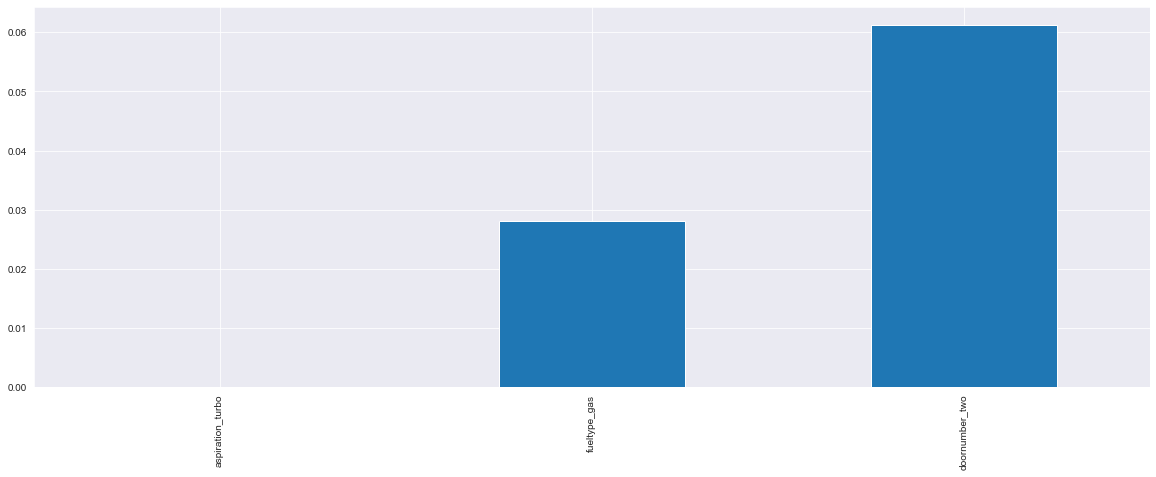

In [22]:
# concat the train sets
train = pd.concat([X_train, y_train],axis=1)

# create an empty dictionary
p_ls = {}

# iterate over every binary feature
for feat in cat_vars:
    
    # separate the binary distributions
    class_0 = train[train[feat]==0]['price']
    class_1 = train[train[feat]==1]['price']
    
    # run the test and store the p values in the dictionaru
    stat, p = mannwhitneyu(class_0,class_1)
    p_ls[feat] = p

# plot out the p values
p_ls = pd.Series(p_ls)
p_ls.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [23]:
# print out the p values
p_ls.sort_values(ascending=True)

aspiration_turbo    0.000094
fueltype_gas        0.028123
doornumber_two      0.061282
dtype: float64

We reject the null hypothesis at the 5% significance level for:
- aspiration_turbo
- enginelocation_rear
- fueltype_gas

We fail to reject the null hypothesis at the 5% significance level for doornumber_two.

In [24]:
# grab features where p < 0.05
selected_features = [feat for feat in p_ls.keys() if p_ls[feat] <= 0.05]
selected_features

['fueltype_gas', 'aspiration_turbo']

Ultimately, the degree of predictive association between the binary variables and the target would still be determined by an effect size computation. The p values only tell us whether or not the variables are associated with the target. 

Let's create a funtion that can compute the effect sizes of the binary variables.

In [25]:
def mw_effect_size(df, feat, target):
    
    # separate the two samples
    class_0 = df[df[feat]==0][target]
    class_1 = df[df[feat]==1][target]
    
    # grab the p value and the test statistic
    U1, p = mannwhitneyu(class_0,class_1)
    nx, ny = len(class_0), len(class_1)
    
    # calculate the z score
    U2 = (nx*ny) - U1
    U = min(U1, U2)
    N = nx + ny
    z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
    
    # compute the effect size
    r = z / np.sqrt(N)
    return r

<AxesSubplot:>

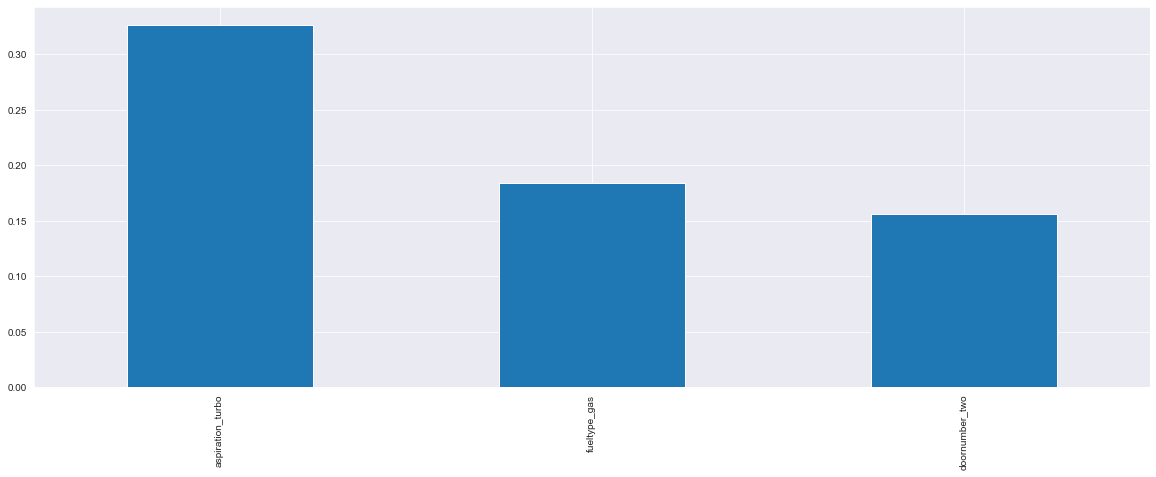

In [26]:
# empty dictionary to store the sizes
sizes = {}

# iterate over each variable
for var in cat_vars:
    
    # store the size and variable name in the dictionary
    size = mw_effect_size(train, var, 'price')
    sizes[var] = abs(size)

# plot out the sizes in ascending order
sizes = pd.Series(sizes)
sizes.sort_values(ascending=False).plot.bar(figsize=(20,7))

In [27]:
# print out the sizes
sizes.sort_values(ascending=False)

aspiration_turbo    0.326640
fueltype_gas        0.183601
doornumber_two      0.156497
dtype: float64

Notice an inverse relationship between p-values and effect sizes, i.e. the variables with the smallest p-values have the largest effect sizes. As far as their relationship with the target variable, all the binary variables have small effect sizes (<0.3).

### Discrete/Categorical Variables: Kruskal-Wallis H Test

We consider the discrete variables as categorical variables because of their low 'cardinality'. Just like the categorical binary variables, we will also test for parity in at least one sample distribution at the 5% significance level.

- **NULL HYPOTHESIS (H0):** All data samples were drawn from the same distribution.
- **ALTERNATIVE HYPOTHESIS (H1):** At least one sample was drawn from a different distribution.

In [28]:
# print out the discrete variables
discrete_vars = ['country', 'carbody', 'drivewheel', 'cylindernumber', 'fuelsystem', 'symboling']

In [29]:
# print out the number of unique categories present in each discrete variable
for feature in discrete_vars:
    print(f'{feature}: {X_train[feature].nunique()}')

country: 7
carbody: 5
drivewheel: 3
cylindernumber: 6
fuelsystem: 7
symboling: 6


Our test will be run on varuables with 7, 6, 5 and 3 different samples per the variable categories.

In [30]:
# create an empty dictionary
p_ls = {}
effect_sizes = {}

# iterate over the features
for feat in discrete_vars:
    
    # store the categories if the variable in a list
    categories = train[feat].value_counts().index.to_list()
    
    # create an empty list to store the samples from the categories
    samples = []
    
    # iterate over the categories
    # and append each category sample to the list
    for label in categories:
        samples.append(train[train[feat]==label]['price'])
    
    # group/rename the samples for the variables with 8 categories
    # run the kruskal operation and store the p values in the empty dictionary
    if len(samples) == 7:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        class_4 = samples[3]
        class_5 = samples[4]
        class_6 = samples[5]
        class_7 = samples[6]
        stat,p = kruskal(class_1,class_2,class_3,class_4,class_5,class_6,class_7)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq
        
    # group/rename the samples for the variables with 5 categories
    # run the kruskal operation and store the p values in the empty dictionary
    elif len(samples) == 6:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        class_4 = samples[3]
        class_5 = samples[4]
        class_6 = samples[5]
        stat,p = kruskal(class_1,class_2,class_3,class_4,class_5,class_6)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq
    
    # group/rename the samples for the variables with 5 categories
    # run the kruskal operation and store the p values in the empty dictionary
    elif len(samples) == 5:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        class_4 = samples[3]
        class_5 = samples[4]
        stat,p = kruskal(class_1,class_2,class_3,class_4,class_5)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq
    
    # group/rename the samples for the variables with 4 categories
    # run the kruskal operation and store the p values in the empty dictionary
    else:
        class_1 = samples[0]
        class_2 = samples[1]
        class_3 = samples[2]
        stat,p = kruskal(class_1,class_2,class_3)
        p_ls[feat] = p
        n = len(train)
        H = stat
        eta_sq = H / (((n**2)-1) / (n+1))
        effect_sizes[feat] = eta_sq

<AxesSubplot:>

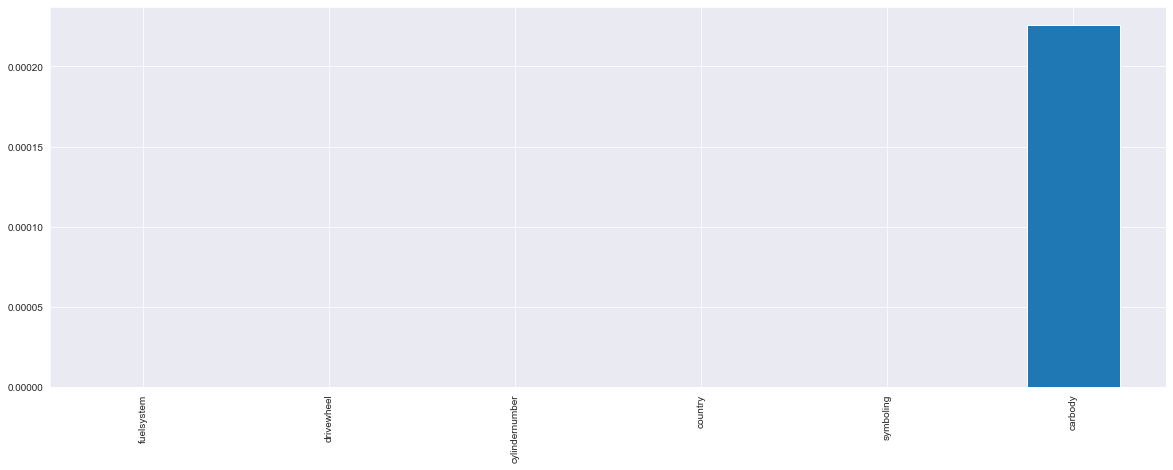

In [31]:
# plot out the p_values
p_ls = pd.Series(p_ls)
p_ls.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [32]:
# print out the p values
p_ls.sort_values(ascending=True)

fuelsystem        1.018104e-16
drivewheel        3.250180e-16
cylindernumber    3.999746e-11
country           2.262186e-09
symboling         3.110718e-09
carbody           2.259940e-04
dtype: float64

Let's go ahead and select the features that violate the null hypothesis at the 5% significance level. We will add the features to our existing list of selected features.

In [33]:
selected_features = selected_features + [feat for feat in p_ls.keys() if p_ls[feat] <= 0.05]

# print out the selected features
selected_features

['fueltype_gas',
 'aspiration_turbo',
 'country',
 'carbody',
 'drivewheel',
 'cylindernumber',
 'fuelsystem',
 'symboling']

Like we did for the binary variables, we will compute and observe the effect sizes of the variables with particular emphasis on the features that have violated our null hypothesis.

<AxesSubplot:>

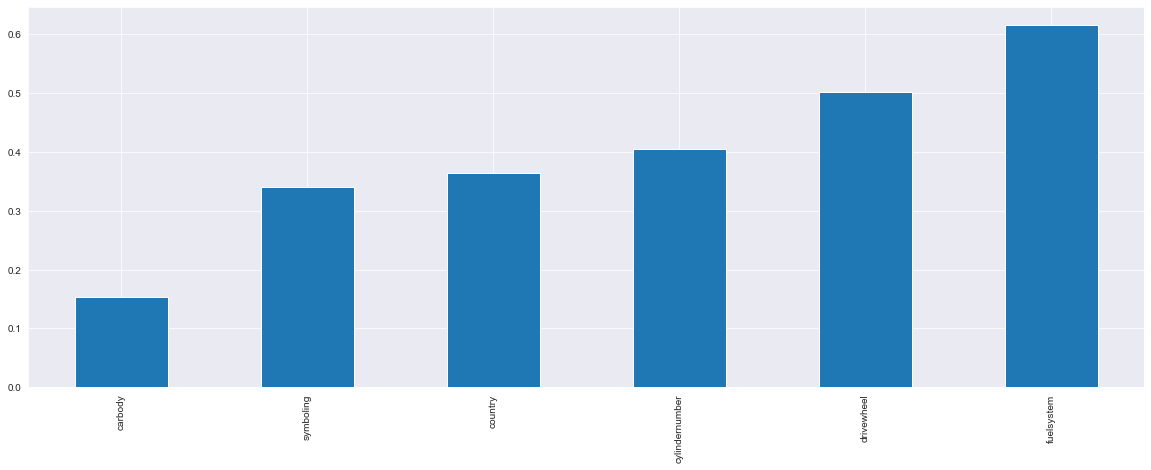

In [34]:
effect_sizes = pd.Series(effect_sizes)
effect_sizes.sort_values(ascending=True).plot.bar(figsize=(20,7))

In [35]:
effect_sizes.sort_values(ascending=False)

fuelsystem        0.615946
drivewheel        0.502291
cylindernumber    0.404888
country           0.363258
symboling         0.340015
carbody           0.153083
dtype: float64

In [36]:
small = []
moderate = []
large = []

for feature,value in zip(effect_sizes.index,effect_sizes.values):
    
    if value < 0.06:
        small.append(feature)
    elif (value >= 0.06) & (value < 0.14):
        moderate.append(feature)
    else:
        large.append(feature)
        
print(f'Number of features with small effects: {len(small)}')
print(f'Number of features with moderate effects: {len(moderate)}')
print(f'Number of features with large effects: {len(large)}')

Number of features with small effects: 0
Number of features with moderate effects: 0
Number of features with large effects: 6


Our discrete variables all have large effects on car prices.

### Continuous Variables: Spearman's Rank Correlation

Finally, we will measure association with the target for the continuous variables in the feature space. Before running the test, let's run a scatterplot of variables to get an eye-test of the relationship.

In [37]:
# outline the continuous variables
cont_vars = ['wheelbase',
             'carlength',
             'carwidth',
             'carheight',
             'curbweight',
             'enginesize',
             'boreratio',
             'stroke',
             'compressionratio',
             'horsepower',
             'peakrpm',
             'citympg',
             'highwaympg']

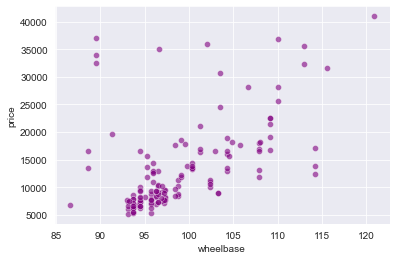

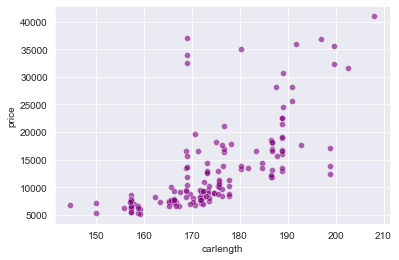

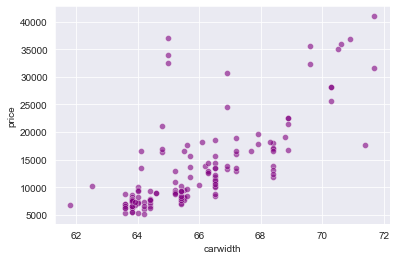

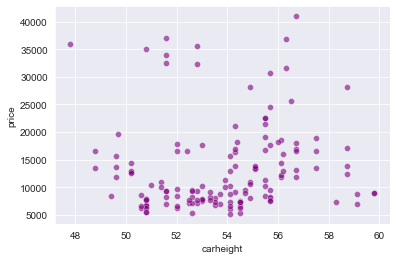

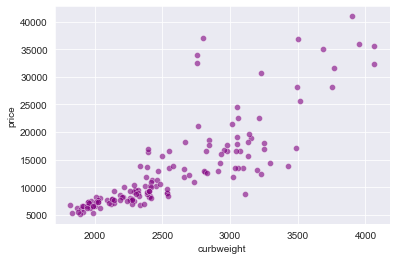

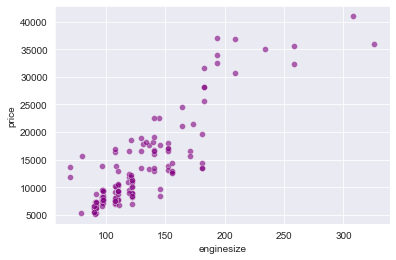

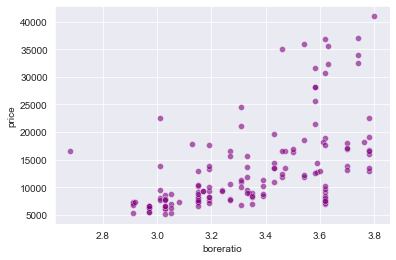

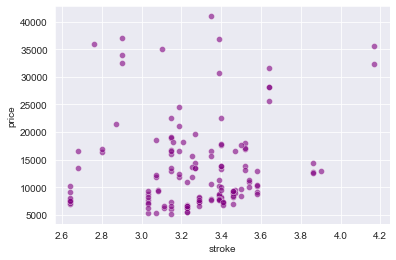

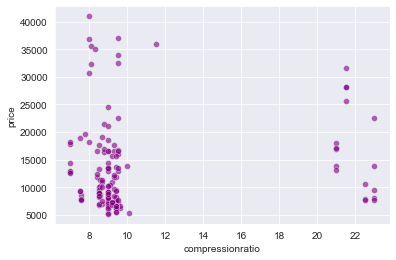

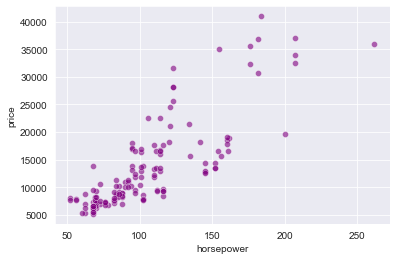

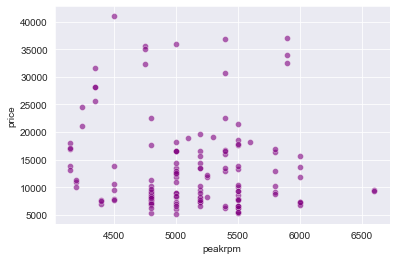

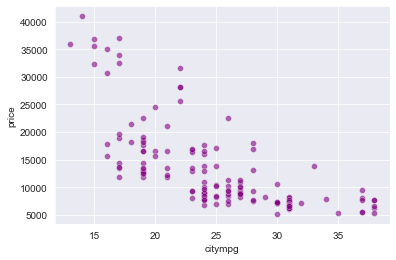

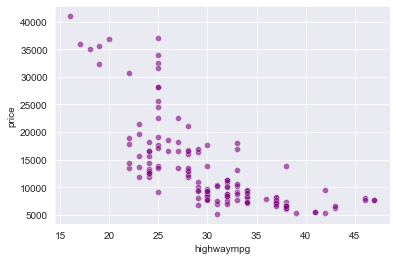

In [38]:
for var in cont_vars:
    sns.scatterplot(x=var, y='price', data=train, alpha=0.6, color='purple')
    plt.xlabel(var)
    plt.ylabel('price')
    plt.show()

In [39]:
p_ls = {} # empty dictionary to store p vales
coefs = {} # empty dictionary to store corr coefs

# iterate over the continuous variables
for var in cont_vars:
    
    # compute and store coef and p value in the dictionaries
    coef, p = spearmanr(train[var], train['price'])
    p_ls[var] = p
    coefs[var] = abs(coef)

<AxesSubplot:>

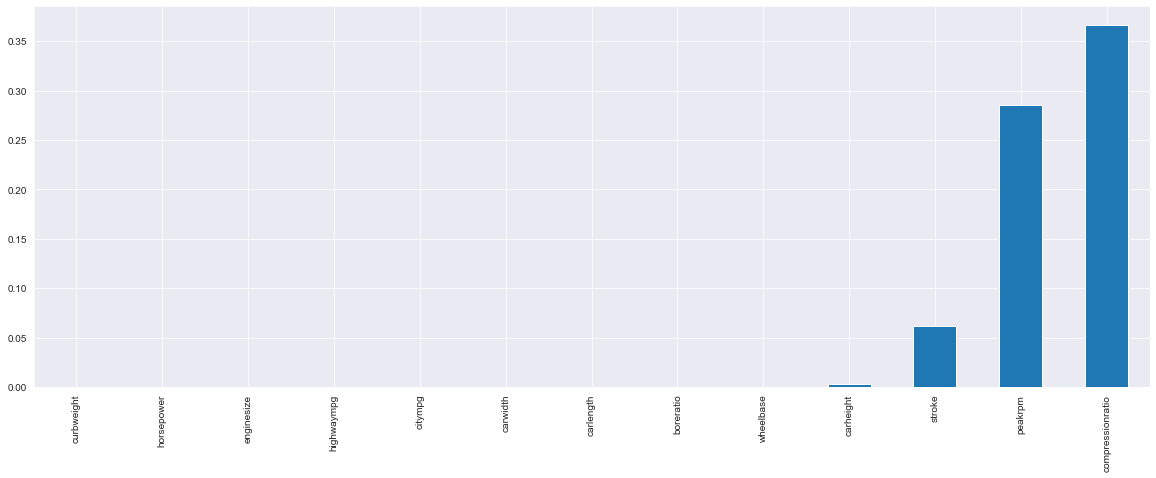

In [40]:
# plot out the p values
p_ls = pd.Series(p_ls)
p_ls.sort_values(ascending=True).plot.bar(figsize=(20,7))

<AxesSubplot:>

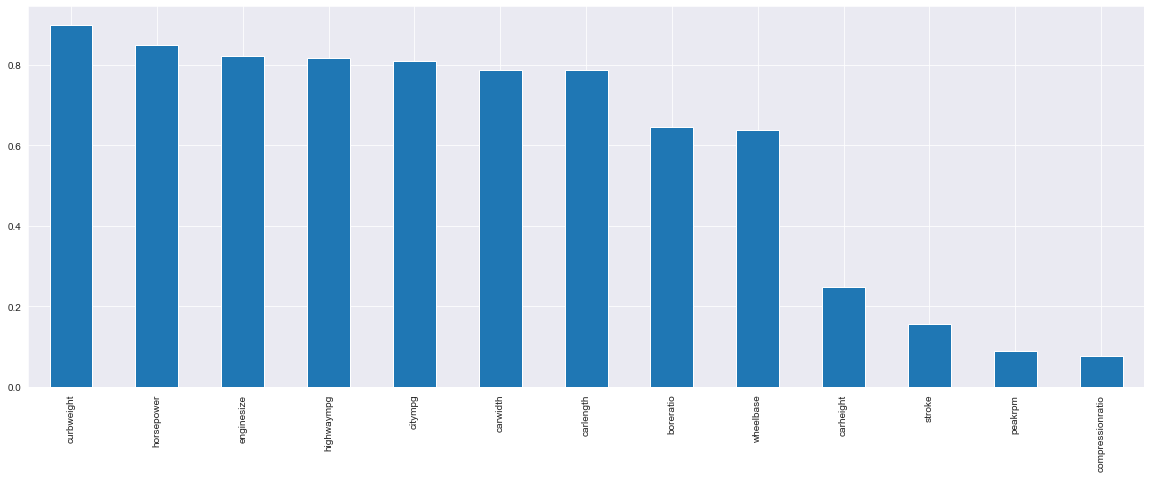

In [41]:
# plot out the coefficients
coefs = pd.Series(coefs)
coefs.sort_values(ascending=False).plot.bar(figsize=(20,7))

We notice an inverse relationship between p values and coefficients for the continuous variables.

In [42]:
# select the features with p-values < 0.05
selected_features = selected_features + [feat for feat in p_ls.keys() if p_ls[feat] <= 0.05]

# print out the selected features
selected_features

['fueltype_gas',
 'aspiration_turbo',
 'country',
 'carbody',
 'drivewheel',
 'cylindernumber',
 'fuelsystem',
 'symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'horsepower',
 'citympg',
 'highwaympg']

In [43]:
# save our selected features for the next notebook
pd.Series(selected_features).to_csv('selected_features.csv', index=False)